# 라이브러리

In [496]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
from tqdm import tqdm

# time
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_columns', None)  # 모든 컬럼 다 보이게 설정

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 지리 라이브러리
from geopy.distance import geodesic

# 전처리용
from itertools import combinations

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 윈도우용 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # 말굿 고딕 (Windows 기본 한글 폰트)
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 머신러닝 - 전처리, 모델, 평가
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 머신러닝 알고리즘 (필요에 따라 선택적으로 추가)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier

# 텍스트 처리
from rapidfuzz import process, fuzz

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# # # 딥러닝 (선택사항)
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout

# 모델 해석
import shap



# 데이터 불러오기 및 전처리

In [226]:
sequence = 2

# 데이터 불러오기
train_df = pd.read_csv(f'./data3/{sequence}_train_done.csv', encoding='cp949')
test_df  = pd.read_csv(f'./data3/{sequence}_test_done.csv', encoding='cp949')

# 공통 컬럼 존재 가정
full_df = pd.concat([train_df, test_df], ignore_index=True)

# 날짜 컬럼이 '일시'라고 가정, datetime으로 변환
full_df['일시'] = pd.to_datetime(full_df['일시'])

# # 정렬
# full_df = full_df.sort_values('일시')

In [228]:
train_df.shape,\
test_df.shape,\
full_df.shape,\
full_df.dropna(subset='공기질').shape

((79830, 59), (21574, 59), (101404, 59), (101404, 59))

In [230]:
# 공기질 결측 제거된 전체 df
full_df_without_na = full_df.dropna(subset='공기질')

df = full_df_without_na

In [232]:
df.shape

(101404, 59)

# 함수 정의

## generate_date_splits

In [363]:
def generate_date_splits(분할단위, 시작일시, 종료일시):
    """
    분할단위 기준으로 기준일시 리스트 생성

    Parameters:
    - 분할단위: '분기', '월', '일', '시간' 중 택 1
    - 시작일시: datetime 객체 또는 문자열
    - 종료일시: datetime 객체 또는 문자열

    Returns:
    - 기준일시 리스트 (datetime 객체 리스트)
    """
    if isinstance(시작일시, str):
        시작일시 = pd.to_datetime(시작일시)
    if isinstance(종료일시, str):
        종료일시 = pd.to_datetime(종료일시)

    delta_map = {
        '분기': relativedelta(months=3),
        '월': relativedelta(months=1),
        '주': relativedelta(weeks=1),
        '일': relativedelta(days=1),
        '시간': relativedelta(hours=1),
    }

    if 분할단위 not in delta_map:
        raise ValueError("분할단위는 '분기', '주', '월', '일', '시간' 중 하나여야 합니다.")

    delta = delta_map[분할단위]

    기준일시_리스트 = []
    현재 = 시작일시

    while 현재 < 종료일시:
        기준일시_리스트.append(현재)
        현재 += delta

    return 기준일시_리스트

In [365]:
# 작동 테스트, 잘 됨
# # pd.DataFrame(generate_date_splits('월', '2022-02-01 00:00:00', '2023-12-31 23:59:59'))

## split_train_test

In [367]:
def split_train_test(full_df, 분할단위, 기준일시):
    """
    기준일시 및 분할단위에 따라 train/test를 나누는 함수

    Parameters:
    - full_df: 전체 통합 데이터프레임 (공기질 결측 제거 완료 상태)
    - 분할단위: '분기', '월', '주' '일', '시간' 중 하나
    - 기준일시: datetime 객체 또는 'YYYY-MM-DD HH:MM:SS' 형식 문자열

    Returns:
    - train_df, test_df
    """

    # 문자열이면 datetime으로 변환
    if isinstance(기준일시, str):
        기준일시 = pd.to_datetime(기준일시)

    # 다음 분할 시작 시점 계산
    if 분할단위 == '분기':
        다음시작일시 = 기준일시 + relativedelta(months=3)
    elif 분할단위 == '월':
        다음시작일시 = 기준일시 + relativedelta(months=1)
    elif 분할단위 == '주':
        다음시작일시 = 기준일시 + relativedelta(weeks=1)
    elif 분할단위 == '일':
        다음시작일시 = 기준일시 + relativedelta(days=1)
    elif 분할단위 == '시간':
        다음시작일시 = 기준일시 + relativedelta(hours=1)
    else:
        raise ValueError("분할단위는 '분기', '월', '주', '일', '시간' 중 하나여야 합니다.")

    # 데이터 분리
    train_df = full_df[full_df['일시'] < 기준일시]
    test_df = full_df[(full_df['일시'] >= 기준일시) & (full_df['일시'] < 다음시작일시)]

    return train_df.copy(), test_df.copy()


In [369]:
# # 작동 테스트. 잘되는것 같음.
# train, test = split_train_test(df, '시간', '2022-05-01 00:00:00')
# print(train.shape, test.shape)
# print('train')
# print(train['일시'].min())
# print(train['일시'].max())
# print('test')
# print(test['일시'].min())
# print(test['일시'].max())

## train_and_evaluate_model

In [524]:
# 모델 훈련 함수
def train_and_evaluate_model(X_train, y_train, X_test, y_test, cat_cols, num_cols):
    # 전처리
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])
    
    # 파이프라인 구성
    # pipeline = Pipeline(steps=[
    #     ('preprocess', preprocessor),
    #     ('rfc', RandomForestClassifier(random_state=42))
    # ])
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('lgbm', LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=-1  # 로그 출력 끔
        ))
    ])
    
    # 학습
    pipeline.fit(X_train, y_train)
    
    # 예측 및 평가
    y_true = np.array(y_test).ravel()
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    return y_true, y_pred, y_prob

## evaluate_model

In [514]:
#평가함수
def evaluate_model(y_true, y_pred, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # ks = abs(np.cumsum(np.bincount(y_true[y_prob.argsort()])))
    # ks_value = max(np.abs(ks - np.linspace(0, ks[-1], len(ks))))
    # Youden Index 계산
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    youden_index = max(tpr - fpr)
    
    misclassification_rate = (fp + fn) / (tp + tn + fp + fn)

    return {
        'AUROC': auc,
        'Youden': youden_index,
        'MCR': misclassification_rate
    }


## evaluate_for_date

In [609]:
# 통합 평가 함수
def evaluate_for_date(full_df, reference_date, period, cat_cols, num_cols, target_col):
    """
    하나의 기준일 기준으로:
    - train/test 분리
    - 모델 훈련 및 예측
    - 평가 지표 계산

    Returns:
    - dict: {'기준일': date, 'AUROC': float, 'Youden': float, 'MCR': float}
    """

    # 데이터 분리
    temp_train_df, temp_test_df = split_train_test(full_df, period, reference_date)

    # ✅ 데이터가 비어있으면 건너뜀
    if len(temp_train_df) == 0 or len(temp_test_df) == 0:
        print(f"[SKIP] {reference_date.strftime('%Y-%m-%d')} - 학습/테스트 데이터 없음")
        return None
        
    # 세트 구성
    temp_X_train = temp_train_df[cat_cols + num_cols]
    temp_y_train = temp_train_df[target_col]
    temp_X_test  = temp_test_df[cat_cols + num_cols]
    temp_y_test  = temp_test_df[target_col]

    # 모델 학습 및 예측
    temp_y_true, temp_y_pred, temp_y_prob = train_and_evaluate_model(
        temp_X_train, temp_y_train, temp_X_test, temp_y_test, cat_cols, num_cols
    )

    # 평가
    metrics = evaluate_model(temp_y_true, temp_y_pred, temp_y_prob)

    return {
        'ref_date': reference_date,
        'AUROC': metrics['AUROC'],
        'Youden': metrics['Youden'],
        'MCR': metrics['MCR']
    }

## model_eval_record

In [540]:
# 모델 성능 결과기록 함수
def model_eval_record(metrics, result_df):
    result_df.loc[len(result_df)] = {
        'ref_date': i,
        'AUROC': metrics['AUROC'],
        'Youden': metrics['Youden'],
        'MCR': metrics['MCR']
    }
    return result_df

## result_chart

In [670]:
def result_chart(result_df, period='월', base=None, caution=0.9):

    if base is None:
        base = {}

    # melt: long format
    df_long = result_df.melt(
        id_vars='ref_date',
        value_vars=['AUROC', 'Youden', 'MCR'],
        var_name='metric',
        value_name='value'
    )

    # plot
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_long, x='ref_date', y='value', hue='metric', marker='o')

    # # baseline 라인 추가
    # for metric_name in ['AUROC', 'Youden', 'MCR']:
    #     if metric_name in base:
    #         baseline_value = base[metric_name] * caution
    #         if metric_name != 'MCR':
    #             baseline_value = base[metric_name] * caution
    #         else:
    #             baseline_value = base[metric_name] * (2 - caution)
    #         plt.axhline(y=baseline_value, color='red', linestyle='--', linewidth=1, alpha=0.5)
    #         plt.text(result_df['ref_date'].min(), baseline_value + 0.01,
    #                  f"{metric_name} baseline", color='red', fontsize=9, va='bottom')

    # baseline 라인 추가
    for metric_name in ['AUROC', 'Youden', 'MCR']:
        if metric_name in base:
            # 낮을수록 좋은 MCR은 (2 - caution), 나머지는 caution
            adjustment = (2 - caution) if metric_name == 'MCR' else caution
            baseline_value = base[metric_name] * adjustment

            plt.axhline(y=baseline_value, color='red', linestyle='--', linewidth=1, alpha=0.5)
            plt.text(result_df['ref_date'].min(), baseline_value + 0.01,
                     f"{metric_name} baseline(90%)", color='red', fontsize=9, va='bottom')
    
    plt.title(f'MLOps {period} 단위 모델 성능 추이')
    plt.xlabel('기준일')
    plt.ylabel('지표 값')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 실험

## 데이터 세팅

In [212]:
id_cols = ['일시']
target_col = ['공기질']
cat_cols = ['역명_호선', '주중주말']
num_cols = [x for x in df.columns if x not in id_cols+target_col+cat_cols]
# num_cols = [df.columns for x not in id_cols+target_cols]
print(f'total columns - {len(df.columns)} \n num cols - {len(num_cols)}')

total columns - 58 
 num cols - 55


## 베이스 모델 (연간)
 - (정의) 2022을 학습, 2023을 테스트한 모델
 - 2022는 별도로 val 하지 않음
 - gbm을 사용함

In [244]:
X_train = train_df[cat_cols+num_cols]
y_train = train_df[target_col]
X_test  = test_df[cat_cols+num_cols]
y_test  = test_df[target_col]

In [567]:
# 전처리: 원핫인코딩 + 스케일링
start = time.time()

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# 파이프라인 구성
# pipeline = Pipeline(steps=[
#     ('preprocess', preprocessor),
#     ('rfc', RandomForestClassifier(random_state=42))
# ])
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('lgbm', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=-1  # 로그 출력 끔
    ))
])
# 학습
pipeline.fit(X_train, y_train)

# 예측 및 평가
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

end = time.time()
print(f"총 실행 시간: {end - start:.2f}초")

총 실행 시간: 0.88초


In [568]:
result = evaluate_model(np.array(y_test).ravel(), y_pred, y_prob)

In [577]:
# 중요도 확인
# 모델 내부 feature importance 추출
# importances = pipeline.named_steps['rfc'].feature_importances_
# importances = pipeline.named_steps['lgbm'].feature_importances_
importances = pipeline.named_steps['lgbm'].booster_.feature_importance(importance_type='gain')
# 전처리에서 변환된 컬럼 이름 가져오기
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)

# 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

pd.DataFrame(importance_df.head(20)).reset_index(drop=True)  # 상위 10개 중요 변수 확인

,feature,importance
0,역명_호선_서울역_1,35204.830542
1,운행횟수,34706.257259
2,30cm지중온도,19625.083139
3,역명_호선_신림_2,17487.543390
4,증기압,13883.999803
5,역명_호선_홍대입구_2,12031.209509
6,hour,11445.605172
7,하차수_lag1,9299.112559
8,month,8980.863906
9,5cm지중온도_minus_30cm지중온도,8331.768618


In [573]:
# {'AUROC': 0.7904324574624362,
# 'Youden': 0.4358585892816728,
# '오분류율': 0.2709279688513952}
# 'model'을 맨 앞에 추가
result = {'model': 'lgbm', **result}
result_df = pd.DataFrame([result])
result_df.index.name = 'model name'
result_df

,model,AUROC,Youden,MCR
model name,,,,
0,lgbm,0.803187,0.443035,0.267498


In [355]:
# AUROC lower caution line (90% of base model performance)
auroc_alert_threshold = round(result_df['AUROC'].values[0]*0.9,6)
print(f'auroc_alert_threshold = {auroc_alert_threshold}')

auroc_alert_threshold = 0.711389


## 분기

In [658]:
# 실험세팅 pd.DataFrame(generate_date_splits('월', '2022-02-01 00:00:00', '2023-12-31 23:59:59'))
period = '분기' # 분기, 월, 주, 일, 시간
start = '2022-04-01 00:00:00'
end   = '2023-12-31 23:59:59'

In [660]:
# 빈 데이터프레임
result_df = pd.DataFrame(columns=['ref_date', 'AUROC', 'Youden', 'MCR'])

# 훈련, 테스트 데이터프레임 만들기
reference_date = generate_date_splits(period, start, end)

for i in tqdm(reference_date, desc='학습중'):
    metrics = evaluate_for_date(full_df, i, period, cat_cols, num_cols, target_col)
    # 결과 데이터프레임에 추가
    model_eval_record(metrics, result_df)

학습중: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


In [661]:
result_df

,ref_date,AUROC,Youden,MCR
0,2022-04-01,0.805446,0.467329,0.279109
1,2022-07-01,0.811147,0.465774,0.253843
2,2022-10-01,0.846381,0.536369,0.234695
3,2023-01-01,0.797033,0.433718,0.304028
4,2023-04-01,0.803790,0.460940,0.265875
5,2023-07-01,0.793488,0.411780,0.244864
6,2023-10-01,0.838551,0.505352,0.240291


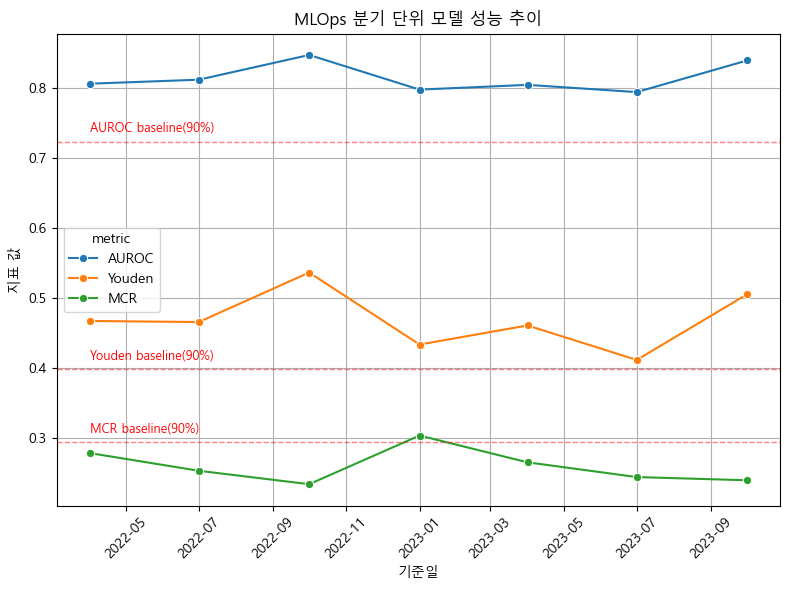

In [672]:
result_chart(result_df, period=period, base=result, caution=0.9)

## 월

In [678]:
# 실험세팅 pd.DataFrame(generate_date_splits('월', '2022-02-01 00:00:00', '2023-12-31 23:59:59'))
period = '월' # 분기, 월, 주, 일, 시간
start = '2022-02-01 00:00:00'
end   = '2023-11-30 23:59:59'

In [680]:
# 빈 데이터프레임
result_df = pd.DataFrame(columns=['ref_date', 'AUROC', 'Youden', 'MCR'])

# 훈련, 테스트 데이터프레임 만들기
reference_date = generate_date_splits(period, start, end)
reference_date
for i in tqdm(reference_date, desc='학습중'):
    metrics = evaluate_for_date(full_df, i, period, cat_cols, num_cols, target_col)
    if metrics is None:
        continue  # 데이터 없어서 건너뛰기
    # 결과 데이터프레임에 추가
    model_eval_record(metrics, result_df)

학습중:   0%|          | 0/23 [00:00<?, ?it/s]

[SKIP] 2022-01-01 - 학습/테스트 데이터 없음


학습중:  61%|██████    | 14/23 [00:07<00:06,  1.37it/s]

[SKIP] 2023-03-01 - 학습/테스트 데이터 없음


학습중: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


In [681]:
result_df

,ref_date,AUROC,Youden,MCR
0,2022-02-01,0.874179,0.588291,0.204680
1,2022-03-01,0.793416,0.445928,0.307337
2,2022-04-01,0.799441,0.458465,0.308741
3,2022-05-01,0.845075,0.554465,0.241002
4,2022-06-01,0.842962,0.537789,0.234433
5,2022-07-01,0.821732,0.489990,0.240642
6,2022-08-01,0.879736,0.579808,0.163769
7,2022-09-01,0.853761,0.552646,0.193370
8,2022-10-01,0.836810,0.509979,0.241927
9,2022-11-01,0.884789,0.602735,0.221349


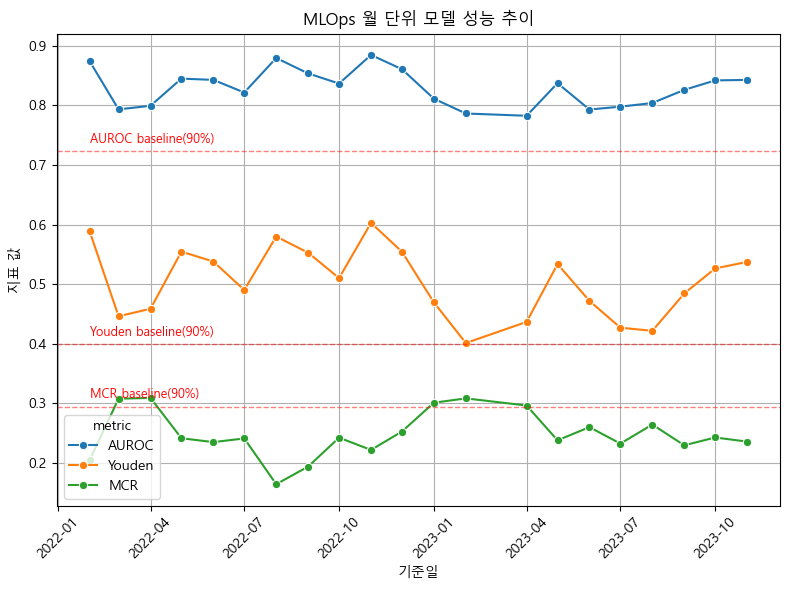

In [682]:
result_chart(result_df, period=period, base=result, caution=0.9)

In [683]:
result_df.to_csv(f'result_{period}.csv', encoding='cp949')

## 주

In [689]:
# 실험세팅 pd.DataFrame(generate_date_splits('월', '2022-02-01 00:00:00', '2023-12-31 23:59:59'))
period = '주' # 분기, 월, 주, 일, 시간
start = '2022-02-01 00:00:00'
end   = '2023-12-31 23:59:59'

In [691]:
# 빈 데이터프레임
result_df = pd.DataFrame(columns=['ref_date', 'AUROC', 'Youden', 'MCR'])

# 훈련, 테스트 데이터프레임 만들기
reference_date = generate_date_splits(period, start, end)
reference_date
for i in tqdm(reference_date, desc='학습중'):
    metrics = evaluate_for_date(full_df, i, period, cat_cols, num_cols, target_col)
    if metrics is None:
        continue  # 데이터 없어서 건너뛰기
    # 결과 데이터프레임에 추가
    model_eval_record(metrics, result_df)

학습중:   0%|          | 0/105 [00:00<?, ?it/s]

[SKIP] 2022-01-01 - 학습/테스트 데이터 없음


학습중:  60%|██████    | 63/105 [00:35<00:19,  2.11it/s]

[SKIP] 2023-03-04 - 학습/테스트 데이터 없음
[SKIP] 2023-03-11 - 학습/테스트 데이터 없음
[SKIP] 2023-03-18 - 학습/테스트 데이터 없음
[SKIP] 2023-03-25 - 학습/테스트 데이터 없음


학습중: 100%|██████████| 105/105 [01:13<00:00,  1.44it/s]


In [692]:
result_df

,ref_date,AUROC,Youden,MCR
0,2022-01-08,0.768445,0.397146,0.294261
1,2022-01-15,0.880850,0.615178,0.188475
2,2022-01-22,0.800149,0.467531,0.281095
3,2022-01-29,0.863885,0.562809,0.261391
4,2022-02-05,0.931846,0.700435,0.153524
...,...,...,...,...
95,2023-12-02,0.827148,0.520030,0.253731
96,2023-12-09,0.892108,0.669666,0.200000
97,2023-12-16,0.856506,0.602824,0.250653
98,2023-12-23,0.753839,0.404113,0.270408


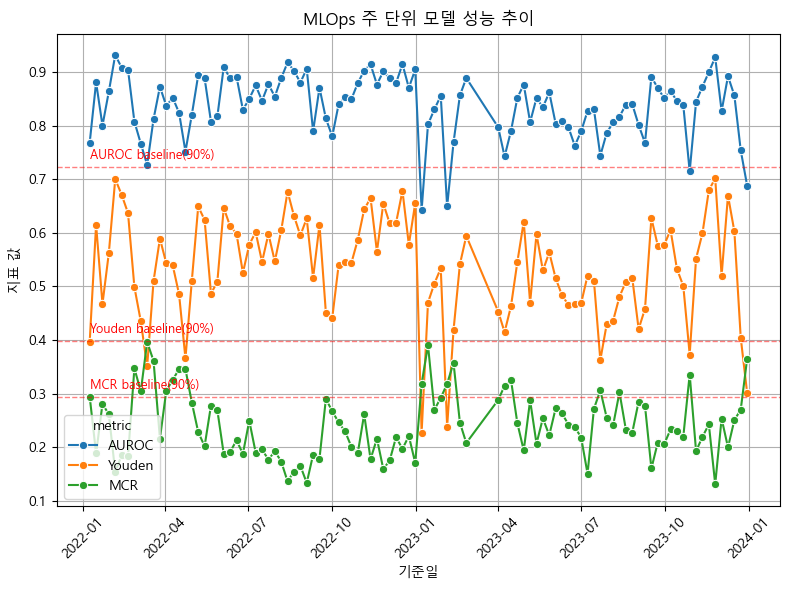

In [693]:
result_chart(result_df, period=period, base=result, caution=0.9)

In [694]:
result_df.to_csv(f'result_{period}.csv', encoding='cp949')

## 일

In [699]:
# 실험세팅 pd.DataFrame(generate_date_splits('월', '2022-02-01 00:00:00', '2023-12-31 23:59:59'))
period = '일' # 분기, 월, 주, 일, 시간
start = '2022-02-01 00:00:00'
end   = '2023-12-31 23:59:59'

In [701]:
# 빈 데이터프레임
result_df = pd.DataFrame(columns=['ref_date', 'AUROC', 'Youden', 'MCR'])

# 훈련, 테스트 데이터프레임 만들기
reference_date = generate_date_splits(period, start, end)
reference_date
for i in tqdm(reference_date, desc='학습중'):
    metrics = evaluate_for_date(full_df, i, period, cat_cols, num_cols, target_col)
    if metrics is None:
        continue  # 데이터 없어서 건너뛰기
    # 결과 데이터프레임에 추가
    model_eval_record(metrics, result_df)

학습중:  57%|█████▋    | 395/699 [03:58<02:32,  2.00it/s]

[SKIP] 2023-03-01 - 학습/테스트 데이터 없음
[SKIP] 2023-03-02 - 학습/테스트 데이터 없음
[SKIP] 2023-03-03 - 학습/테스트 데이터 없음
[SKIP] 2023-03-04 - 학습/테스트 데이터 없음
[SKIP] 2023-03-05 - 학습/테스트 데이터 없음


학습중:  57%|█████▋    | 401/699 [03:58<00:54,  5.49it/s]

[SKIP] 2023-03-06 - 학습/테스트 데이터 없음
[SKIP] 2023-03-07 - 학습/테스트 데이터 없음
[SKIP] 2023-03-08 - 학습/테스트 데이터 없음
[SKIP] 2023-03-09 - 학습/테스트 데이터 없음


학습중:  58%|█████▊    | 405/699 [03:59<00:35,  8.30it/s]

[SKIP] 2023-03-10 - 학습/테스트 데이터 없음
[SKIP] 2023-03-11 - 학습/테스트 데이터 없음
[SKIP] 2023-03-12 - 학습/테스트 데이터 없음
[SKIP] 2023-03-13 - 학습/테스트 데이터 없음
[SKIP] 2023-03-14 - 학습/테스트 데이터 없음


학습중:  59%|█████▊    | 410/699 [03:59<00:23, 12.20it/s]

[SKIP] 2023-03-15 - 학습/테스트 데이터 없음
[SKIP] 2023-03-16 - 학습/테스트 데이터 없음
[SKIP] 2023-03-17 - 학습/테스트 데이터 없음
[SKIP] 2023-03-18 - 학습/테스트 데이터 없음
[SKIP] 2023-03-19 - 학습/테스트 데이터 없음


학습중:  60%|█████▉    | 416/699 [03:59<00:17, 15.79it/s]

[SKIP] 2023-03-20 - 학습/테스트 데이터 없음
[SKIP] 2023-03-21 - 학습/테스트 데이터 없음
[SKIP] 2023-03-22 - 학습/테스트 데이터 없음
[SKIP] 2023-03-23 - 학습/테스트 데이터 없음
[SKIP] 2023-03-24 - 학습/테스트 데이터 없음


학습중:  60%|██████    | 420/699 [03:59<00:17, 16.40it/s]

[SKIP] 2023-03-25 - 학습/테스트 데이터 없음
[SKIP] 2023-03-26 - 학습/테스트 데이터 없음
[SKIP] 2023-03-27 - 학습/테스트 데이터 없음
[SKIP] 2023-03-28 - 학습/테스트 데이터 없음


학습중:  61%|██████    | 423/699 [04:00<00:15, 17.58it/s]

[SKIP] 2023-03-29 - 학습/테스트 데이터 없음
[SKIP] 2023-03-30 - 학습/테스트 데이터 없음
[SKIP] 2023-03-31 - 학습/테스트 데이터 없음


학습중: 100%|██████████| 699/699 [08:08<00:00,  1.43it/s]


In [702]:
result_df

,ref_date,AUROC,Youden,MCR
0,2022-02-01,0.662976,0.297583,0.384937
1,2022-02-02,0.677641,0.279115,0.376569
2,2022-02-03,0.900216,0.622145,0.204167
3,2022-02-04,0.966513,0.793808,0.108787
4,2022-02-05,0.951421,0.762589,0.133891
...,...,...,...,...
663,2023-12-27,0.844444,0.722222,0.203390
664,2023-12-28,0.514254,0.208333,0.343284
665,2023-12-29,0.832479,0.605128,0.203704
666,2023-12-30,0.804574,0.541580,0.301587


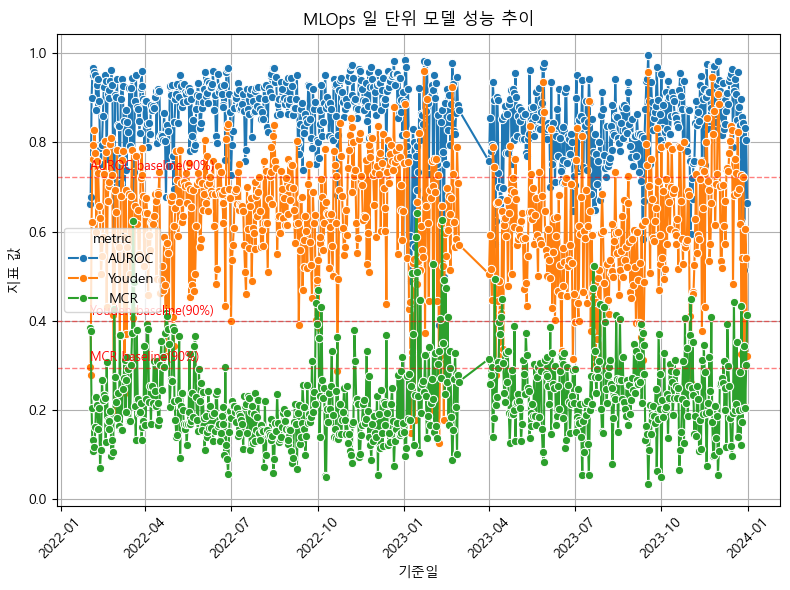

In [703]:
result_chart(result_df, period=period, base=result, caution=0.9)

In [704]:
result_df.to_csv(f'result_{period}.csv', encoding='cp949')

In [709]:
# 얼마나 컷오프를 넘겼는지 확인
result

{'model': 'lgbm',
 'AUROC': 0.8031867695160124,
 'Youden': 0.44303477777011413,
 'MCR': 0.26749791415592844}

In [711]:
result_df

,ref_date,AUROC,Youden,MCR
0,2022-02-01,0.662976,0.297583,0.384937
1,2022-02-02,0.677641,0.279115,0.376569
2,2022-02-03,0.900216,0.622145,0.204167
3,2022-02-04,0.966513,0.793808,0.108787
4,2022-02-05,0.951421,0.762589,0.133891
...,...,...,...,...
663,2023-12-27,0.844444,0.722222,0.203390
664,2023-12-28,0.514254,0.208333,0.343284
665,2023-12-29,0.832479,0.605128,0.203704
666,2023-12-30,0.804574,0.541580,0.301587


In [761]:
caution_roc = sum(result_df['AUROC'] < result['AUROC']*0.9)
caution_you = sum(result_df['Youden'] < result['Youden']*0.9)
caution_mcr = sum(result_df['MCR'] > result['MCR']*1.1)

In [775]:
np.array([caution_roc, caution_you, caution_mcr])

array([ 46,  41, 135])

In [786]:
np.array([caution_roc, caution_you, caution_mcr]) / 668 * 100

array([ 6.88622754,  6.13772455, 20.20958084])